# Time-based Features and Moving Averages
## CNN-LSTM using All-in-one Approach (7.4 from report)
### Per Day Analysis

Anastasios Koutsogiannopoulos, 03321

Fani Banou, 03322

Ioannis Sakellariou, 03144

In [20]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, Dropout, BatchNormalization, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error

### Data Loading and Preprocessing Functions

In [21]:
def mount_drive():
    """
    Mount Google Drive if running on Google Colab.
    """
    try:
        from google.colab import drive
        drive.mount('/content/drive/')
    except ImportError:
        print("Not running on Google Colab; skipping drive mount.")


In [22]:
def load_and_preprocess_data(file_path):
    """
    Load the dataset from the CSV file, convert UNIX timestamps to datetime,
    set the datetime as index, and resample the data to daily frequency.
    """
    # Load dataset
    data = pd.read_csv(file_path)

    # Convert 'unix' column to datetime and set as index
    data['date'] = pd.to_datetime(data['unix'], unit='s')
    data.set_index('date', inplace=True)
    data.sort_index(ascending=True, inplace=True)

    # Use only the 'close' column
    numeric_data = data[['close']].copy()

    # Resample data to daily frequency in case the data is in minutes
    data_daily = numeric_data.resample('1d').mean()

    # Add time-based features and cyclic features
    data_daily = add_time_features(data_daily)
    data_daily = add_cyclic_features(data_daily)

    # Compute Moving Averages
    data_daily['MA_5'] = data_daily['close'].rolling(window=5).mean()
    data_daily['MA_24'] = data_daily['close'].rolling(window=24).mean()

    # Drop rows with NaN values due to rolling windows
    data_daily.dropna(inplace=True)

    return data_daily

In [23]:
def add_time_features(df):
    """
    Add time-based features day, weekday, month extracted from the index.
    """
    df['day'] = df.index.day
    df['weekday'] = df.index.weekday
    df['month'] = df.index.month
    return df

In [24]:
def add_cyclic_features(df):
    """
    Add cyclic sine and cosine representations for weekday, and month.
    """
    # Cyclic features for weekday
    df['weekday_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
    df['weekday_cos'] = np.cos(2 * np.pi * df['weekday'] / 7)
    # Cyclic features for month
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    return df

In [25]:
def create_final_dataset(data_daily, feature_columns, target_column):
    """
    Create the final dataset containing selected features and the target.
    """
    return data_daily[feature_columns + [target_column]]

In [26]:
def split_dataset(data, train_end_date, test_start_date, test_end_date):
    """
    Split the dataset into training and testing sets based on specified date ranges.
    """
    train_data = data[:train_end_date]
    test_data = data[test_start_date:test_end_date]
    return train_data, test_data

In [27]:
def scale_data(train_data, test_data):
    """
    Scale the training and testing data using MinMaxScaler.
    """
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_data)
    test_scaled = scaler.transform(test_data)
    return train_scaled, test_scaled, scaler

### Sequence Generation Functions

In [28]:
def create_sequences_multi_step(data, seq_length, horizon):
    """
    Create input sequences and corresponding multi-step target sequences.
    """
    X, y = [], []
    # Create samples only until there are enough steps for the forecast horizon
    for i in range(len(data) - seq_length - horizon + 1):
        X.append(data[i:i+seq_length, :-1])
        y.append(data[i+seq_length:i+seq_length+horizon, -1])
    return np.array(X), np.array(y)

### Model Building and Training Functions

In [29]:
def build_multi_step_model(sequence_length, num_features, forecast_horizon):
    """
    Build a Sequential model for direct multi-step forecasting.
    The model consists of convolutional layers, an LSTM block, and dense layers.
    """
    model = Sequential([
        # Convolutional Block
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(sequence_length, num_features)),
        BatchNormalization(),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.5),

        # LSTM Block: Stacked LSTM layers to capture temporal dependencies
        LSTM(256, return_sequences=True, input_shape=(sequence_length, num_features)),
        BatchNormalization(),
        Dropout(0.3),
        LSTM(128, return_sequences=False),
        BatchNormalization(),
        Dropout(0.2),


        # Dense Block: Process the extracted features
        Dense(64, activation='relu'),
        Dropout(0.2),

        # Final Dense Layer to produce the multi-step forecast
        Dense(forecast_horizon, activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])
    return model


In [30]:
def train_model(model, X_train, y_train, epochs=100, batch_size=256, validation_split=0.2, patience=15):
    """
    Train the model using the given training data and early stopping to prevent overfitting.
    """
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=validation_split,
        shuffle=False,
        callbacks=[early_stopping]
    )
    return history

In [31]:
def plot_loss_history(history):
    """
    Plot the evolution of training and validation loss over epochs.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.title('Loss Evolution During Training')
    plt.show()

### Forecasting and Evaluation Functions

In [32]:
def make_forecast(model, train_scaled, sequence_length, num_features, scaler, feature_columns, forecast_horizon):
    """
    Make a multi-step forecast using the last available sequence from the training data.

    The model outputs scaled predictions which are then converted back to the original scale
    using the scaler's inverse_transform.
    """
    # Prepare input sequence for prediction features only
    X_input = train_scaled[-sequence_length:, :-1].reshape(1, sequence_length, num_features)

    # Predict the multi-step forecast output shape: 1, forecast_horizon
    forecast_scaled = model.predict(X_input)
    forecast_scaled = forecast_scaled.flatten()

    # Create a dummy array for the feature columns to use with the scaler's inverse_transform
    dummy = np.zeros((forecast_scaled.shape[0], len(feature_columns)))

    # Concatenate dummy features with the forecast target values to create a complete vector
    forecast_concat = np.concatenate([dummy, forecast_scaled.reshape(-1, 1)], axis=1)

    # Inverse transform to retrieve the forecast in the original scale extract the target column
    forecast_unscaled = scaler.inverse_transform(forecast_concat)[:, -1]
    return forecast_unscaled

In [33]:
def plot_forecast(test_data, target_column, forecast_unscaled, forecast_horizon):
    """
    Plot the actual target values versus the predicted forecast.
    """
    test_index = test_data.index[:forecast_horizon]
    plt.figure(figsize=(12, 6))
    plt.plot(test_index, test_data[target_column].values[:forecast_horizon],
             label="Actual Close", color='blue', linestyle='dashed')
    plt.plot(test_index, forecast_unscaled, label="Predicted Close", color='red')
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.title("Actual vs Predicted Close Prices (Direct Multi-Step Forecasting)")
    plt.legend()
    plt.grid(True)
    plt.show()

In [34]:
def evaluate_forecast(actual, forecast):
    """
    Evaluate the forecast using common regression metrics and print the results.
    """

    mae = mean_absolute_error(actual, forecast)
    mse = mean_squared_error(actual, forecast)
    rmse = np.sqrt(mse)

    print("Mean Absolute Error (MAE):", mae)
    print("Mean Squared Error (MSE):", mse)
    print("Root Mean Squared Error (RMSE):", rmse)

In [35]:
def run_multiple_experiments_multi_step(num_runs, X_train, y_train, train_scaled, sequence_length,
                                        num_features, scaler, feature_columns, forecast_horizon,
                                        test_data, target_column):
    """
    Run the multi-step forecasting experiment multiple times num_runs,
    and average the training histories, forecasts, and evaluation metrics.
    """
    training_histories = []  # To store training histories for each run
    forecasts = []           # To store forecast predictions for each run
    metrics_list = []        # To store evaluation metrics for each run
    train_times = []         # To store execution times for model training
    forecast_times = []      # To store execution times for forecasting

    # Actual target values from test data for forecast_horizon
    actual = test_data[target_column].values[:forecast_horizon]

    for run in range(num_runs):
        print(f"Run {run+1}/{num_runs}")
        # Build the multi-step forecasting model
        model = build_multi_step_model(sequence_length, num_features, forecast_horizon)

        # Train the model
        start_time = time.time()
        history = train_model(model, X_train, y_train)
        train_time = time.time() - start_time
        train_times.append(train_time)

        training_histories.append(history)

        # Make forecast using the last sequence from the training data
        start_time = time.time()
        forecast_unscaled = make_forecast(model, train_scaled, sequence_length, num_features, scaler, feature_columns, forecast_horizon)
        forecast_time = time.time() - start_time
        forecast_times.append(forecast_time)

        forecasts.append(forecast_unscaled)

        # Compute evaluation metrics for this run
        from sklearn.metrics import mean_absolute_error, mean_squared_error
        mae = mean_absolute_error(actual, forecast_unscaled)
        mse = mean_squared_error(actual, forecast_unscaled)
        rmse = np.sqrt(mse)
        metrics_list.append({'MAE': mae, 'MSE': mse, 'RMSE': rmse})

    # Determine the minimum number of epochs across runs due to early stopping
    min_epochs = min(len(hist.history['loss']) for hist in training_histories)
    # Average the training and validation loss curves over the minimum number of epochs
    avg_loss = np.mean([hist.history['loss'][:min_epochs] for hist in training_histories], axis=0)
    avg_val_loss = np.mean([hist.history['val_loss'][:min_epochs] for hist in training_histories], axis=0)

    # Plot average training history
    plt.figure(figsize=(10, 5))
    epochs_range = range(1, min_epochs+1)
    plt.plot(epochs_range, avg_loss, label='Average Training Loss')
    plt.plot(epochs_range, avg_val_loss, label='Average Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss (MSE)")
    plt.title(f"Average Loss Evolution over {num_runs} Runs")
    plt.legend()
    plt.show()

    # Average the forecast predictions
    avg_forecast = np.mean(np.array(forecasts), axis=0)

    # Plot actual vs. average forecast
    test_index = test_data.index[:forecast_horizon]
    plt.figure(figsize=(12, 6))
    plt.plot(test_index, actual, label="Actual Close", color='blue', linestyle='dashed')
    plt.plot(test_index, avg_forecast, label="Average Predicted Close", color='red')
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.title("Actual vs Average Predicted Close Prices (Multi-Step Forecasting)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Average evaluation metrics over all runs
    avg_metrics = {
         'MAE': np.mean([m['MAE'] for m in metrics_list]),
         'MSE': np.mean([m['MSE'] for m in metrics_list]),
         'RMSE': np.mean([m['RMSE'] for m in metrics_list]),
    }
    print(f"Average Metrics over {num_runs} Runs:")
    print("Mean Absolute Error (MAE):", avg_metrics['MAE'])
    print("Mean Squared Error (MSE):", avg_metrics['MSE'])
    print("Root Mean Squared Error (RMSE):", avg_metrics['RMSE'])

    # Compute and print average execution times
    avg_train_time = np.mean(train_times)
    avg_forecast_time = np.mean(forecast_times)
    print(f"\nAverage Execution Times over {num_runs} Runs:")
    print(f"Model Training Time: {avg_train_time:.4f} seconds")
    print(f"Forecasting Time: {avg_forecast_time:.4f} seconds")


### Main Function

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).

Running multiple experiments...
Run 1/10
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 503ms/step - loss: 1.9733 - mean_absolute_error: 1.1342 - val_loss: 0.1539 - val_mean_absolute_error: 0.3701
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 1.5013 - mean_absolute_error: 0.9624 - val_loss: 0.1432 - val_mean_absolute_error: 0.3555
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 1.0625 - mean_absolute_error: 0.8163 - val_loss: 0.1352 - val_mean_absolute_error: 0.3431
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.8782 - mean_absolute_error: 0.7404 - val_loss: 0.1255 - val_mean_absolute_error: 0.3278
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.7816 - mean_absolute_error: 0.6934 - val_loss: 0.1162 - val_mean_absolute_error: 0.3110
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.6884 - mean_absolute_error: 0.6560 - val_loss: 0.1069 - val_mean_absolute_error: 0.2935
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.6157 - mean_absolute_error: 0.6267 - val_loss: 0.0965 - val_mea

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 464ms/step - loss: 2.1423 - mean_absolute_error: 1.1482 - val_loss: 0.1529 - val_mean_absolute_error: 0.3697
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 1.6566 - mean_absolute_error: 1.0225 - val_loss: 0.1508 - val_mean_absolute_error: 0.3669
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 1.2584 - mean_absolute_error: 0.8872 - val_loss: 0.1463 - val_mean_absolute_error: 0.3603
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 1.0450 - mean_absolute_error: 0.8067 - val_loss: 0.1390 - val_mean_absolute_error: 0.3494
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.9104 - mean_absolute_error: 0.7484 - val_loss: 0.1311 - val_mean_absolute_error: 0.3376
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.8249 - mean_absolute_error: 0.7176 - val_loss: 0.1242 - val_mean_absolute_error: 0.3261
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.7498 - mean_absolute_error: 0.6865 - val_loss: 0.1178 - val_mea

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 492ms/step - loss: 2.1535 - mean_absolute_error: 1.1672 - val_loss: 0.1614 - val_mean_absolute_error: 0.3813
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 1.5885 - mean_absolute_error: 0.9813 - val_loss: 0.1575 - val_mean_absolute_error: 0.3763
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 1.2448 - mean_absolute_error: 0.8748 - val_loss: 0.1521 - val_mean_absolute_error: 0.3693
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 1.0236 - mean_absolute_error: 0.7978 - val_loss: 0.1470 - val_mean_absolute_error: 0.3623
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.8965 - mean_absolute_error: 0.7447 - val_loss: 0.1414 - val_mean_absolute_error: 0.3542
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.7559 - mean_absolute_error: 0.6854 - val_loss: 0.1360 - val_mean_absolute_error: 0.3463
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.7330 - mean_absolute_error: 0.6765 - val_loss: 0.1311 - val_mea

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 465ms/step - loss: 2.2961 - mean_absolute_error: 1.2143 - val_loss: 0.1526 - val_mean_absolute_error: 0.3685
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 1.8243 - mean_absolute_error: 1.0721 - val_loss: 0.1457 - val_mean_absolute_error: 0.3590
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 1.4320 - mean_absolute_error: 0.9525 - val_loss: 0.1366 - val_mean_absolute_error: 0.3462
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 1.1829 - mean_absolute_error: 0.8678 - val_loss: 0.1274 - val_mean_absolute_error: 0.3330
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.9925 - mean_absolute_error: 0.7908 - val_loss: 0.1194 - val_mean_absolute_error: 0.3213
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.9105 - mean_absolute_error: 0.7542 - val_loss: 0.1113 - val_mean_absolute_error: 0.3091
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.8030 - mean_absolute_error: 0.7091 - val_loss: 0.1027 - val_m

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 498ms/step - loss: 1.6472 - mean_absolute_error: 0.9971 - val_loss: 0.1518 - val_mean_absolute_error: 0.3668
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 1.4771 - mean_absolute_error: 0.9527 - val_loss: 0.1466 - val_mean_absolute_error: 0.3609
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 1.0310 - mean_absolute_error: 0.8050 - val_loss: 0.1442 - val_mean_absolute_error: 0.3581
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.9646 - mean_absolute_error: 0.7799 - val_loss: 0.1425 - val_mean_absolute_error: 0.3556
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.8356 - mean_absolute_error: 0.7249 - val_loss: 0.1407 - val_mean_absolute_error: 0.3527
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.7499 - mean_absolute_error: 0.6896 - val_loss: 0.1385 - val_mean_absolute_error: 0.3488
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.7033 - mean_absolute_error: 0.6643 - val_loss: 0.1350 - val

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 480ms/step - loss: 2.0978 - mean_absolute_error: 1.1431 - val_loss: 0.1534 - val_mean_absolute_error: 0.3702
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 1.5206 - mean_absolute_error: 0.9820 - val_loss: 0.1515 - val_mean_absolute_error: 0.3676
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 1.3665 - mean_absolute_error: 0.9270 - val_loss: 0.1474 - val_mean_absolute_error: 0.3612
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 1.0541 - mean_absolute_error: 0.8184 - val_loss: 0.1412 - val_mean_absolute_error: 0.3513
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.9490 - mean_absolute_error: 0.7722 - val_loss: 0.1349 - val_mean_absolute_error: 0.3406
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.8473 - mean_absolute_error: 0.7274 - val_loss: 0.1293 - val_mean_absolute_error: 0.3306
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.7367 - mean_absolute_error: 0.6855 - val_loss: 0.1224 - val_me

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 455ms/step - loss: 1.9845 - mean_absolute_error: 1.1141 - val_loss: 0.1503 - val_mean_absolute_error: 0.3656
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 1.5533 - mean_absolute_error: 0.9902 - val_loss: 0.1420 - val_mean_absolute_error: 0.3545
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 1.1024 - mean_absolute_error: 0.8211 - val_loss: 0.1338 - val_mean_absolute_error: 0.3430
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.8307 - mean_absolute_error: 0.7135 - val_loss: 0.1255 - val_mean_absolute_error: 0.3307
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.7958 - mean_absolute_error: 0.7014 - val_loss: 0.1150 - val_mean_absolute_error: 0.3133
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.7117 - mean_absolute_error: 0.6684 - val_loss: 0.1059 - val_mean_absolute_error: 0.2973
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.6741 - mean_absolute_error: 0.6462 - val_loss: 0.0998 - val_mea

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 487ms/step - loss: 1.9622 - mean_absolute_error: 1.1077 - val_loss: 0.1506 - val_mean_absolute_error: 0.3673
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 1.6700 - mean_absolute_error: 1.0284 - val_loss: 0.1454 - val_mean_absolute_error: 0.3596
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 1.2525 - mean_absolute_error: 0.8926 - val_loss: 0.1370 - val_mean_absolute_error: 0.3478
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 1.0228 - mean_absolute_error: 0.7976 - val_loss: 0.1288 - val_mean_absolute_error: 0.3357
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.9188 - mean_absolute_error: 0.7628 - val_loss: 0.1214 - val_mean_absolute_error: 0.3244
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.8284 - mean_absolute_error: 0.7226 - val_loss: 0.1150 - val_mean_absolute_error: 0.3145
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.7889 - mean_absolute_error: 0.7091 - val_loss: 0.1103 - val_me

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 511ms/step - loss: 1.5791 - mean_absolute_error: 1.0018 - val_loss: 0.1464 - val_mean_absolute_error: 0.3608
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 1.3150 - mean_absolute_error: 0.9066 - val_loss: 0.1429 - val_mean_absolute_error: 0.3562
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.9848 - mean_absolute_error: 0.7857 - val_loss: 0.1379 - val_mean_absolute_error: 0.3495
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.8816 - mean_absolute_error: 0.7439 - val_loss: 0.1312 - val_mean_absolute_error: 0.3399
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.7739 - mean_absolute_error: 0.6919 - val_loss: 0.1245 - val_mean_absolute_error: 0.3296
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.7120 - mean_absolute_error: 0.6701 - val_loss: 0.1182 - val_mean_absolute_error: 0.3200
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.6720 - mean_absolute_error: 0.6442 - val_loss: 0.1130 - val_me

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 470ms/step - loss: 1.7378 - mean_absolute_error: 1.0444 - val_loss: 0.1511 - val_mean_absolute_error: 0.3675
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 1.4357 - mean_absolute_error: 0.9522 - val_loss: 0.1433 - val_mean_absolute_error: 0.3576
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 1.0413 - mean_absolute_error: 0.8134 - val_loss: 0.1379 - val_mean_absolute_error: 0.3501
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.8870 - mean_absolute_error: 0.7491 - val_loss: 0.1333 - val_mean_absolute_error: 0.3430
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.7785 - mean_absolute_error: 0.7070 - val_loss: 0.1275 - val_mean_absolute_error: 0.3341
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.7377 - mean_absolute_error: 0.6770 - val_loss: 0.1212 - val_mean_absolute_error: 0.3240
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.6751 - mean_absolute_error: 0.6512 - val_loss: 0.1152 - val_m

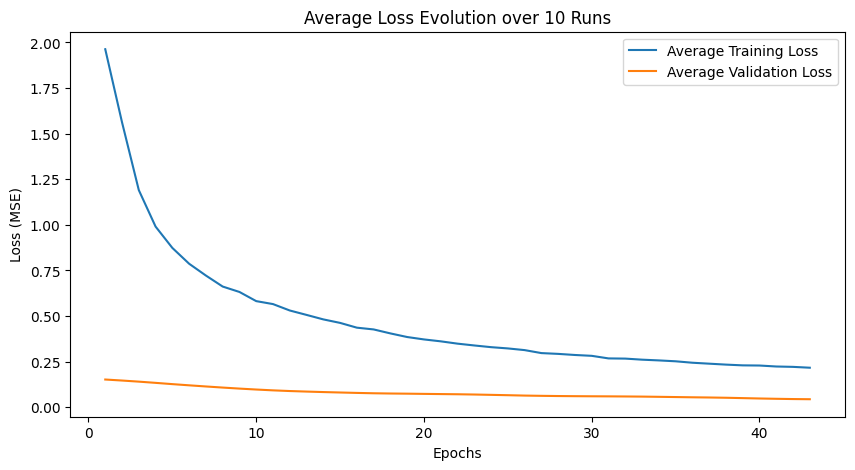

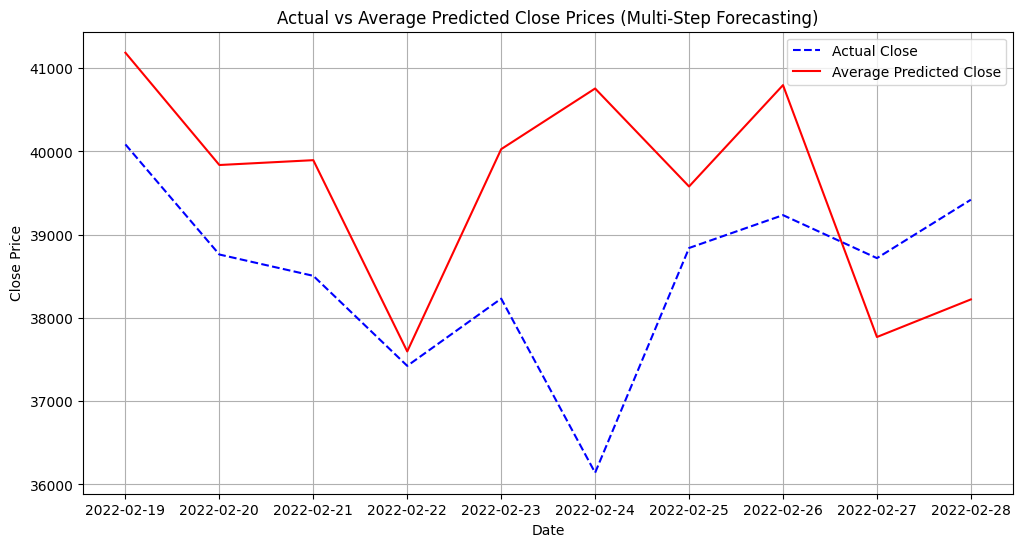

Average Metrics over 10 Runs:
Mean Absolute Error (MAE): 3178.0803145070763
Mean Squared Error (MSE): 16536174.003037194
Root Mean Squared Error (RMSE): 3879.3454008069093

Average Execution Times over 10 Runs:
Model Training Time: 18.4397 seconds
Forecasting Time: 0.3996 seconds


In [40]:
def main():
    # Mount Google Drive
    mount_drive()

    # Define the file path for the dataset
    file_path = "/content/drive/MyDrive/bitcoin-dataset.csv"

    # Load and preprocess the dataset
    data_daily = load_and_preprocess_data(file_path)

    # Define the feature columns and target column
    feature_columns = ['MA_5', 'MA_24',
                       'weekday_sin', 'weekday_cos',
                       'month_sin', 'month_cos']
    target_column = 'close'

    # Create the final dataset with the selected features and target
    data_final = create_final_dataset(data_daily, feature_columns, target_column)

    # Define date ranges for the training and testing sets
    train_end_date = '2022-02-18 23:59:59'
    test_start_date = '2022-02-19 00:00:00'
    test_end_date = '2022-02-28 23:59:59'

    # Split the data into training and testing sets
    train_data, test_data = split_dataset(data_final, train_end_date, test_start_date, test_end_date)

    # Scale the data using MinMaxScaler
    train_scaled, test_scaled, scaler = scale_data(train_data, test_data)

    # Set the sequence length and forecast horizon, forecast horizon equals the number of rows in the test set
    sequence_length = 24
    forecast_horizon = test_scaled.shape[0]

    # Create multi-step sequences from the training data
    X_train, y_train = create_sequences_multi_step(train_scaled, sequence_length, forecast_horizon)

    num_features = X_train.shape[2]

    # # Build the multi-step forecasting model
    # model = build_multi_step_model(sequence_length, num_features, forecast_horizon)
    # model.summary()

    # # Train the model
    # history = train_model(model, X_train, y_train)

    # # Plot the evolution of training and validation loss
    # plot_loss_history(history)

    # # Make a multi-step forecast using the last available sequence from training data
    # forecast_unscaled = make_forecast(model, train_scaled, sequence_length, num_features, scaler, feature_columns, forecast_horizon)

    # # Plot actual vs. predicted close prices
    # plot_forecast(test_data, target_column, forecast_unscaled, forecast_horizon)

    # # Evaluate the forecast using regression metrics
    # actual = test_data[target_column].values[:forecast_unscaled.shape[0]]
    # evaluate_forecast(actual, forecast_unscaled)

    print("\nRunning multiple experiments...")
    run_multiple_experiments_multi_step(num_runs=10, X_train=X_train, y_train=y_train, train_scaled=train_scaled,
                                        sequence_length=sequence_length, num_features=num_features,
                                        scaler=scaler, feature_columns=feature_columns,
                                        forecast_horizon=forecast_horizon, test_data=test_data,
                                        target_column=target_column)


if __name__ == "__main__":
    main()